<a href="https://colab.research.google.com/github/EinarLop/adaptive_reliability_evaluation_system_GCNN/blob/main/2M_3S_E1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Install torch_geometric (everything else is pre-installed in Colab
# Add more rows if woring from Pycharm etc.)
! pip install torch_geometric
#Unzip the archive with data
#!unzip results.zip

In [ ]:
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import glob
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Red all matrix files and convert them into a list of lists
mat_files = sorted(glob.glob('/content/*.mat'))
if '/content/config_1.mat' in mat_files:
    mat_files.remove('/content/config_1.mat')

all_matrices = []
for path in mat_files:
  with open(path, 'r') as f:
    content = f.read()
  # Remove the first and last character ('[' and ']')
  content = content[1:-1]
  string_list = []
  current_row = ''
  start_line = False
  for c in content:
      if c == '[':
          start_line = True
      elif c == ']':
          start_line = False
          string_list.append(current_row)
          current_row = ''
      elif start_line:
          if c != '\n':
              current_row += c
  matrix = []
  for string in string_list:
    vals = string.replace('.', ' ').split()
    vals = [int(v) for v in vals]
    matrix.append(vals)
  all_matrices.append(matrix)

In [ ]:
# Convert adjacency matrices into edge indices.
# An edge index is a 2 x Num_Of_Vert array. Here is an example
# [[ 1, 2, 2, 3],
#  [ 2, 1, 3, 2]]
# You read the list by pairing numbers from top row with numbers from bottom row
# In this example, 1 connects to 2, 2 connects to 1, 2 connects to 3,
# and 3 connects to 2.
# PyTorch Geometric works with this format of edge connection

# List to hold edge indices for all indices
all_edge_indices = []

# Process each matrix in the list
for matrix in all_matrices:
    # Convert the 2D list to a numpy array
    matrix_np = np.array(matrix)

    # Get the indices where there are edges (i.e., non-zero entries)
    edge_indices = np.nonzero(matrix_np)

    # Stack the indices into a 2xN array where each column represents an edge
    edge_index = torch.tensor(np.vstack(edge_indices), dtype=torch.long)

    # Append the edge_index tensor to the list
    all_edge_indices.append(edge_index)

In [ ]:
rel_files = sorted(glob.glob('/content/*.rel'))
all_rels = []

if '/content/config_1.rel' in rel_files:
    rel_files.remove('/content/config_1.rel')

for path in rel_files:
    with open(path, 'r') as f:
        y_val = float(f.read())
    all_rels.append(y_val)


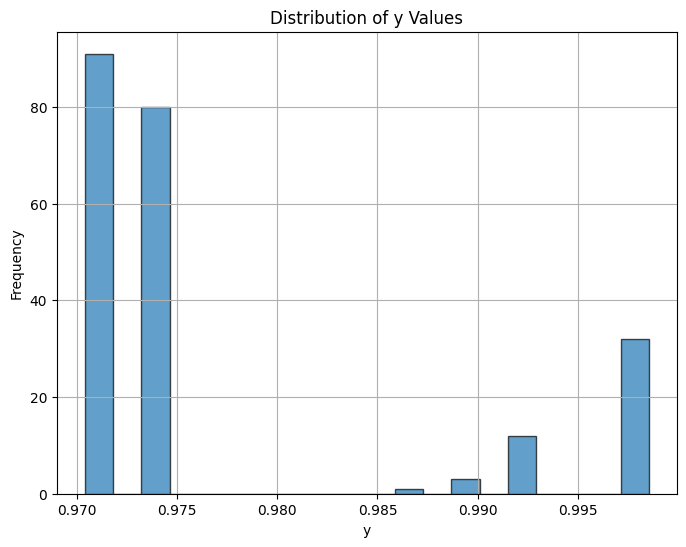

In [ ]:
plt.figure(figsize=(8, 6))
plt.hist(all_rels, bins=20, edgecolor='k', alpha=0.7)  # Adjust bins as needed
plt.title("Distribution of y Values")
plt.xlabel("y")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

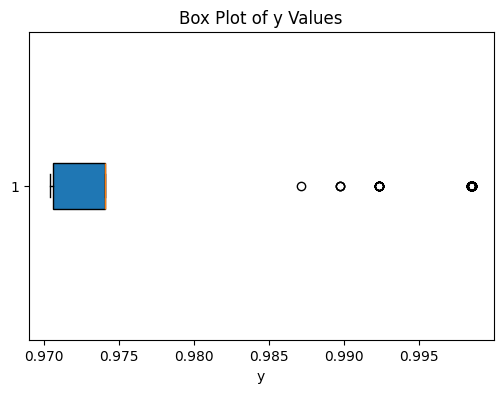

In [ ]:
plt.figure(figsize=(6, 4))
plt.boxplot(all_rels, vert=False, patch_artist=True)
plt.title("Box Plot of y Values")
plt.xlabel("y")
plt.show()

In [ ]:
# Convert the list of float values to a PyTorch tensor
all_rels_tensor = torch.tensor(all_rels)

# Scaling

Amplification k=5 :
- Mean Squared Error on Test Set: 3.4444
- R^2 Score on Test Set: -0.0326

Normalization:
- Mean Squared Error on Test Set: 0.1335
- R^2 Score on Test Set: -0.0004

Standarization:
- Mean Squared Error on Test Set: 1.0188
- R^2 Score on Test Set: -0.0003

In [ ]:
technique = 3

# Amplification
if technique == 0:
  y_min = all_rels_tensor.min()
  y_max = all_rels_tensor.max()
  K = 100
  all_rels_tensor = (all_rels_tensor - y_min) / (y_max - y_min) * K

# Normalization
elif technique == 1:
  y_min = all_rels_tensor.min()
  y_max = all_rels_tensor.max()
  all_rels_tensor = (all_rels_tensor - y_min) / (y_max - y_min)
  print(f'min: {y_min}, max: {y_max}')

# Standarization
elif technique == 2:
  y_mean = all_rels_tensor.mean()
  y_std = all_rels_tensor.std()
  all_rels_tensor = (all_rels_tensor - y_mean) / y_std

# No modificstion
elif technique == 3:
  print(f'min: {y_min}, max: {y_max}')

  pass



min: 0.9704145193099976, max: 0.9985337853431702


In [ ]:
#Create one Data object per graph and put them into one list
# TODO: Create PyTOrch Geometric Dataset object (https://pytorch-geometric.readthedocs.io/en/latest/tutorial/create_dataset.html)
# Each Data object should have node features in a tensor called X,
# (we dont' have any node features yet, that's why there are placeholders)
# target tensor called Y, and edge_index from before.
data_list = []
for i in range(len(all_matrices)):
  num_nodes = len(all_matrices[i])  # Number of nodes from adjacency matrix
  node_features = torch.ones((num_nodes, 1))  # Dummy feature of 1.0 for each node
  edge_index = all_edge_indices[i]
  #TODO: there is one less rel file than mat files. It is because config1 (empty config)
  #Does not have corresponding rel value (which makes sense because empty system doesnt have reliability)
  #Because of that there is one less y valye than x values. I think the easest way to fix this
  #is by removing config1.mat entirely, but I am irested in your thoughts - Pasha
  y = all_rels_tensor[i]

  data = Data(x=node_features, edge_index=edge_index, y=y)
  data_list.append(data)

In [ ]:
from sklearn.model_selection import train_test_split

# Split data and create DataLoader objects for training
train_data_list, test_data_list = train_test_split(data_list, test_size=0.2, random_state=42)


train_loader = DataLoader(train_data_list, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data_list, batch_size=32, shuffle=False)

In [ ]:
# Define a GCN (this one is from PyTorch Geometric tutorial, feel free to experiment)
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool

class GCN(torch.nn.Module):
    def __init__(self, num_node_features = 1):
        super().__init__()
        self.conv1 = GCNConv(num_node_features, 32)
        self.conv2 = GCNConv(32, 16)
        self.fc = torch.nn.Linear(16, 1)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        # First GCN layer
        x = self.conv1(x, edge_index)
        x = F.relu(x)

        # Second GCN layer
        x = self.conv2(x, edge_index)
        x = F.relu(x)

        # Global mean pooling to get graph-level representation
        x = global_mean_pool(x, batch)  # Shape: [batch_size, hidden_channels]

        # Final fully connected layer
        x = torch.sigmoid(self.fc(x))


        return x

In [ ]:
import torch.optim as optim
import time
import os

# Initialize the model, optimizer, and loss function
model = GCN()  # Since our node features have dimension 1
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.MSELoss()

# Training parameters
num_epochs = 2000
patience = 100  # Early stopping patience
min_val_loss = float('inf')  # To track the minimum validation loss
patience_counter = 0  # To count epochs without improvement
checkpoint_path = "best_model.pth"  # File path for the checkpoint

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for data in train_loader:
        optimizer.zero_grad()
        out = model(data).squeeze()  # Shape: [batch_size]
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs  # Accumulate loss

    avg_train_loss = total_loss / len(data_list)

    # Validation Phase
    model.eval()
    total_val_loss = 0

    # Prediction time
    total_predictions = 0
    total_prediction_time = 0

    with torch.no_grad():
        for data in test_loader:
            # Start time
            batch_start_time = time.time()

            out = model(data).squeeze()

            # End time
            batch_end_time = time.time()
            batch_prediction_time = batch_end_time - batch_start_time
            total_prediction_time += batch_prediction_time

            total_predictions += data.num_graphs

            loss = criterion(out, data.y)
            total_val_loss += loss.item() * data.num_graphs

    avg_val_loss = total_val_loss / len(test_data_list)
    avg_prediction_time = total_prediction_time / total_predictions

    print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, Average Prediction Time (s): {avg_prediction_time:.6f} per graph\n")

    # Check for improvement in validation loss
    if avg_val_loss < min_val_loss:
        min_val_loss = avg_val_loss
        patience_counter = 0  # Reset patience counter

        # Save the best model checkpoint
        torch.save(model.state_dict(), checkpoint_path)
    else:
        patience_counter += 1
        print(f"No improvement in validation loss for {patience_counter} epoch(s).\n")

    # Check if patience has been exceeded
    if patience_counter >= patience:
        print(f"Early stopping triggered after {patience} epochs without improvement.")
        break

# Load the best model checkpoint (optional, after training is complete)
if os.path.exists(checkpoint_path):
    model.load_state_dict(torch.load(checkpoint_path))
    print("Loaded the best model from checkpoint.")


Epoch 1/2000, Training Loss: 0.1656, Validation Loss: 0.1830, Average Prediction Time (s): 0.000093 per graph

Epoch 2/2000, Training Loss: 0.1431, Validation Loss: 0.1585, Average Prediction Time (s): 0.000087 per graph

Epoch 3/2000, Training Loss: 0.1186, Validation Loss: 0.1350, Average Prediction Time (s): 0.000094 per graph

Epoch 4/2000, Training Loss: 0.1042, Validation Loss: 0.1388, Average Prediction Time (s): 0.000074 per graph

No improvement in validation loss for 1 epoch(s).

Epoch 5/2000, Training Loss: 0.1068, Validation Loss: 0.1407, Average Prediction Time (s): 0.000069 per graph

No improvement in validation loss for 2 epoch(s).

Epoch 6/2000, Training Loss: 0.1058, Validation Loss: 0.1351, Average Prediction Time (s): 0.000069 per graph

No improvement in validation loss for 3 epoch(s).

Epoch 7/2000, Training Loss: 0.1037, Validation Loss: 0.1334, Average Prediction Time (s): 0.000069 per graph

Epoch 8/2000, Training Loss: 0.1043, Validation Loss: 0.1335, Average 

<ipython-input-125-6678b9b5f8d4>:80: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path))


Mean Squared Error on Test Set: 0.1334
R^2 Score on Test Set: 0.000093216


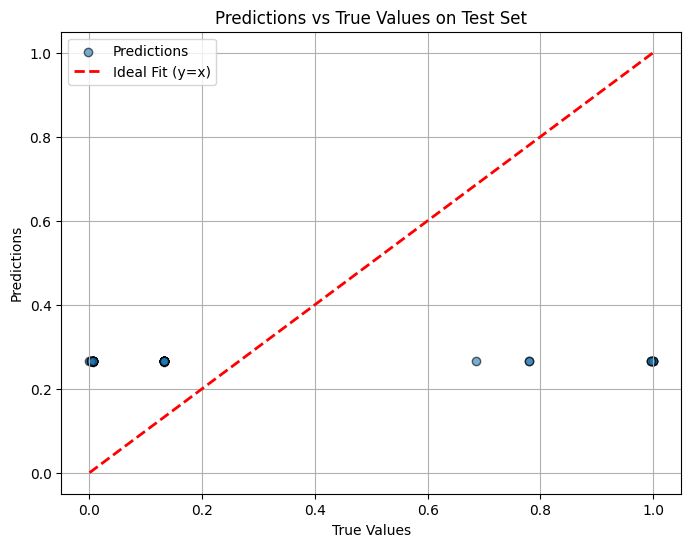

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Evaluate on test data
model.eval()
predictions = []
true_values = []

with torch.no_grad():
    for data in test_loader:
        out = model(data).squeeze()  # Predictions from the model
        predictions.append(out.cpu().numpy())  # Append predictions
        true_values.append(data.y.cpu().numpy())  # Append true values

# Flatten the lists
predictions = [item for sublist in predictions for item in sublist]
true_values = [item for sublist in true_values for item in sublist]



# Calculate Mean Squared Error
mse = mean_squared_error(true_values, predictions)
r2 = r2_score(true_values, predictions)

print(f'Mean Squared Error on Test Set: {mse:.4f}')
print(f'R^2 Score on Test Set: {r2:.9f}')

# Scatter Plot for Predictions vs True Values
plt.figure(figsize=(8, 6))
plt.scatter(true_values, predictions, alpha=0.6, edgecolor='k', label='Predictions')
plt.plot([min(true_values), max(true_values)], [min(true_values), max(true_values)],
         'r--', lw=2, label='Ideal Fit (y=x)')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Predictions vs True Values on Test Set')
plt.legend()
plt.grid()
plt.show()


In [ ]:
for i in range(len(predictions)):
  print(f'prediction: {predictions[i]}, true: {true_values[i]}')


prediction: 0.26521211862564087, true: 0.1317525953054428
prediction: 0.2651640772819519, true: 1.0
prediction: 0.2653054893016815, true: 0.1317525953054428
prediction: 0.2648153305053711, true: 0.1317525953054428
prediction: 0.2648153305053711, true: 0.006893291603773832
prediction: 0.2655954658985138, true: 0.996871292591095
prediction: 0.26461729407310486, true: 0.006893291603773832
prediction: 0.26615580916404724, true: 0.1317525953054428
prediction: 0.2659947872161865, true: 0.006893291603773832
prediction: 0.2653054893016815, true: 0.1317525953054428
prediction: 0.2651640772819519, true: 1.0
prediction: 0.26524338126182556, true: 0.003525075037032366
prediction: 0.26538482308387756, true: 0.003525075037032366
prediction: 0.26594942808151245, true: 0.006893291603773832
prediction: 0.2648438811302185, true: 0.1317525953054428
prediction: 0.2656451463699341, true: 0.006893291603773832
prediction: 0.2655501365661621, true: 0.006893291603773832
prediction: 0.265502005815506, true: 0.0